
# Time Series Analysis for Monthly Mean Total Sunspot number-1749 to 1983
    # Amine Litim

   ##### all libraries are imported within this following cell: 

In [1]:
#pandas
import pandas as pd 
from pandas.plotting import autocorrelation_plot

#matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

#seaborn
import seaborn as sns #for data vizualization

#numpy
import numpy as np

#scipy
from scipy import stats

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#statsmodels
from statsmodels.tsa.stattools import adfuller #for stationarity test
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

#warnings
import warnings
warnings.filterwarnings("ignore")

#figure_size
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (16,8)

### =====================================================================================

## * The dataset selected:  Monthly Mean Total Sunspot Number - form 1749 to 1983


Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

Individual sunspots or groups of sunspots may last anywhere from a few days to a few months, but eventually decay. Sunspots expand and contract as they move across the surface of the Sun, with diameters ranging from 16 km (10 mi) to 160,000 km (100,000 mi) Larger sunspots can be visible from Earth without the aid of a telescope. They may travel at relative speeds, or proper motions, of a few hundred meters per second when they first emerge.

Source: https://en.wikipedia.org/wiki/Sunspot

The units are in degrees Celsius and there are 2820 observations. 

Solar Influences Data Analysis Center - the solar physics research department of the Royal Observatory of Belgium.

    #it contains the date "yyyy/mm/dd" format. 

    #The dataset was taken from www.kaggle.com, and originally hosted by http://sidc.oma.be/ 

    #Dataset title: Monthly Mean Total Sunspot Number
    
    #Provider: the solar physics research department of the Royal Observatory of Belgium.
    
    #Provider source: http://sidc.oma.be/
    
    #Units: Mean total sunspot number.
    
    #Time granularity: Date
    
    #Time range: 1749-01 to 1983-12
    
    #Language: English

### =====================================================================================

In [2]:
sunspot= pd.read_csv('monthly-sunspots.csv', index_col=[0], parse_dates=[0])
#parse_dates=[0]: is to convert the "string" content of the first column to a "datetime" datatype
sunspot

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


### =====================================================================================

## I - preprocessing: 

#### First, we need to analyze the date, detect and eliminate outliers: 

In [3]:
sunspot.describe()

,Sunspots
count,2820.000000
mean,51.265957
std,43.448971
min,0.000000
25%,15.700000
50%,42.000000
75%,74.925000
max,253.800000


#### The standard Deviation here and quartiles range are far from being meaningful, thus , we need to detect the outliers

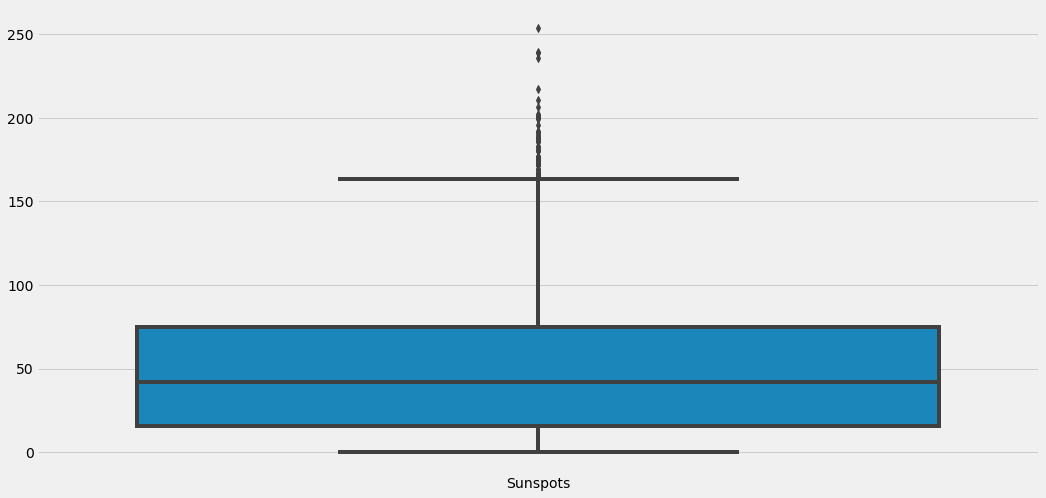

In [4]:
sns.boxplot(data=sunspot) 

#### ==> As we can see from the boxplot, the dataset contains some outliers, so we need to normalize our data

In [5]:
sunspot.size

2820

### =====================================================================================

## II- Visualizing the Data: 

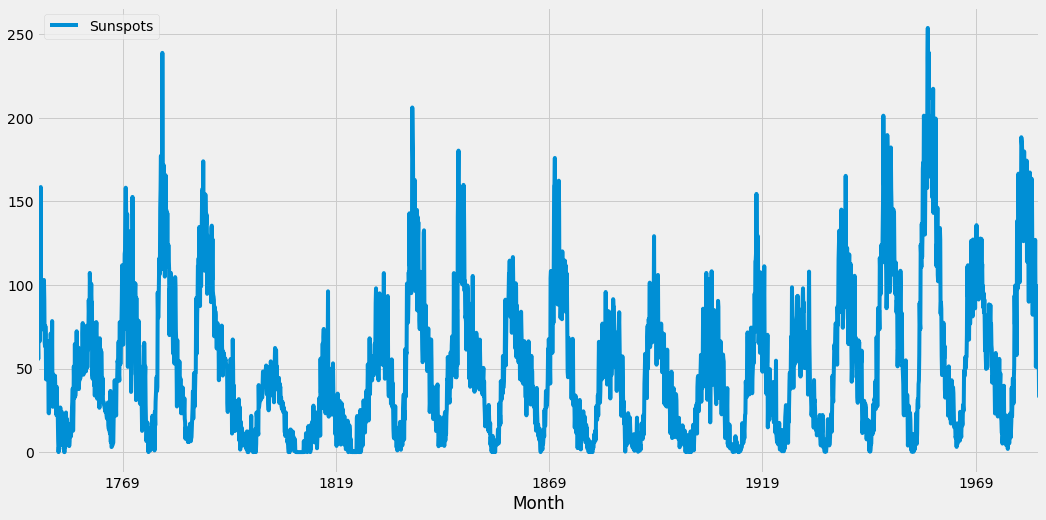

In [6]:
plt.rcParams["figure.figsize"] = (16,8)
sunspot.plot()
plt.show()

#### -->The following plot shows a variation of sunspots from 1749 to 1983 , It is remarkable from the output that our time series may haea seasonality , as the data has cycles & trend (linear one). 
#### --> To make sure the following series is non Stationarity, we should apply the ADF test  (A stationary time series is the one whose statistical properties such as mean, variance, autocorrelation, are all constant over time) 
--------------------------------------
#### We need to smooth the fluctuations based on the "moving average", let's apply the moving average technique on the first 15 values; 

In [7]:
sunspot_mean= sunspot.rolling(window= 15).mean()

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1152x576 with 0 Axes>

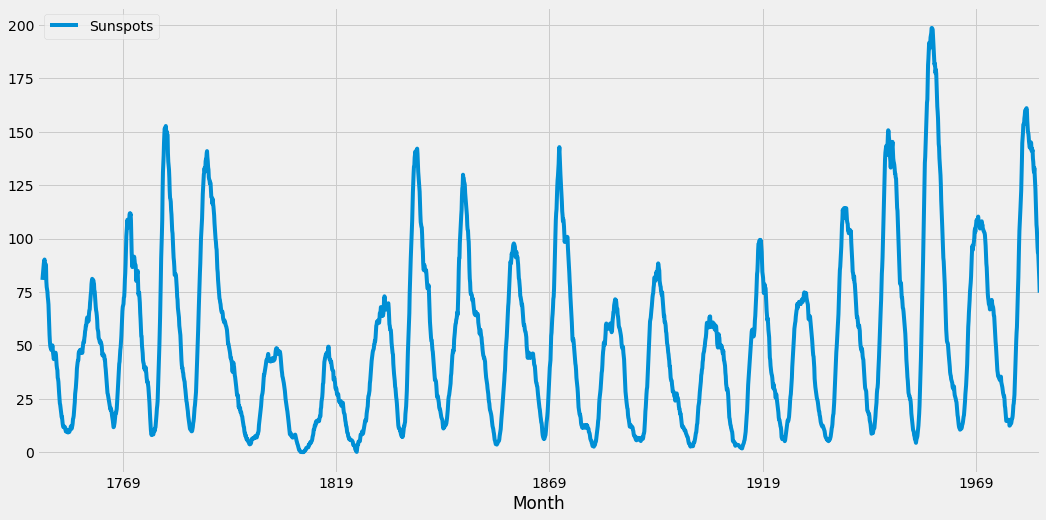

In [8]:
plt.figure(figsize=(16,8))
sunspot_mean.plot()
plt.show

#### The Moving average based graph removed the noise and helped us show that there is a clear non-stationarity 

### =====================================================================================

### Splitting the Data into Train and Test sets: 

In [9]:
original_data = sunspot['Sunspots']

# split into testing & training data
train, test = train_test_split(original_data, test_size=0.2, shuffle=False)

## Box-Cox Transformation test: 

#### The Box-Cox transform is given by:

    # y = (x**lmbda - 1) / lmbda,  for lmbda > 0
    #    log(x),                   for lmbda = 0
    
        #lambda = -1. is a reciprocal transform.
        #lambda = -0.5 is a reciprocal square root transform.
        #lambda = 0.0 is a log transform.
        #lambda = 0.5 is a square root transform.
        #lambda = 1.0 is no transform.

### Here, we need to replace all null values by the mean value of the dataset ( Since Box-cox does not work on null values)

In [10]:
train =train.replace(0.000000,train.mean())

### Then, we apply Box-cox transformation: 

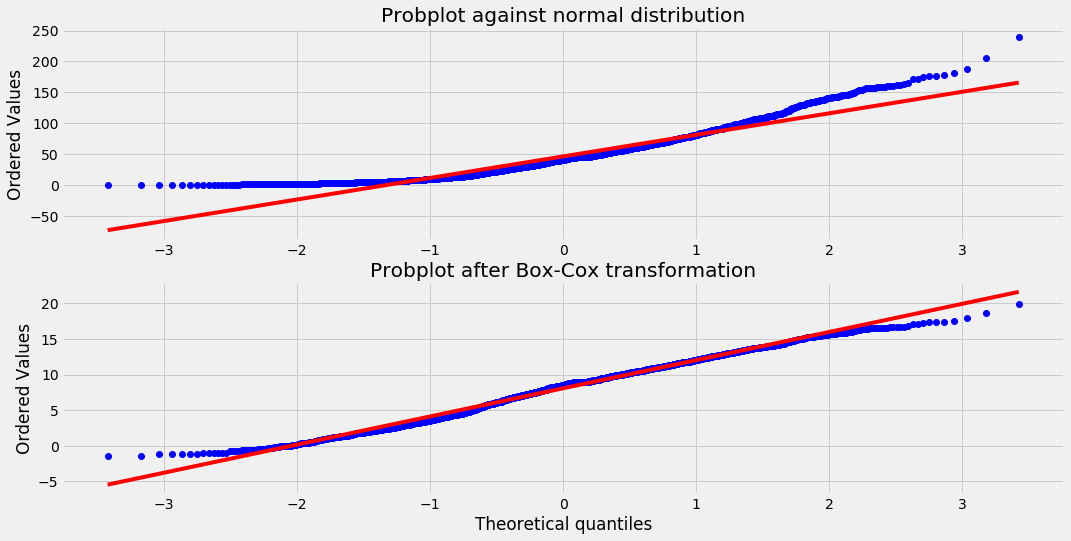

In [11]:
fig = plt.figure()

ax1 = fig.add_subplot(211)
stats.probplot(train, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')


ax2 = fig.add_subplot(212)
new_train, _ = stats.boxcox(train)
stats.probplot(new_train, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

### Now that our data is transformed using Box-Cox, we can run a broader number of tests now. we can step ahead, decompose our time series and check stationarity.

### =====================================================================================

## Decomposition of the Multiplicative time series : 

In [12]:
new_train = pd.DataFrame(data= new_train) 

In [13]:
new_train.describe()

,0
count,2256.000000
mean,8.070273
std,3.963958
min,-1.502877
25%,5.026920
50%,8.523589
75%,10.856226
max,19.939511


### Let's replace null values by the mean value of the time series since the decomposition does not work on null values ( just like the Box-cox test)

In [14]:
new_train =train.replace(0.000000,new_train.mean())

### Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components. Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

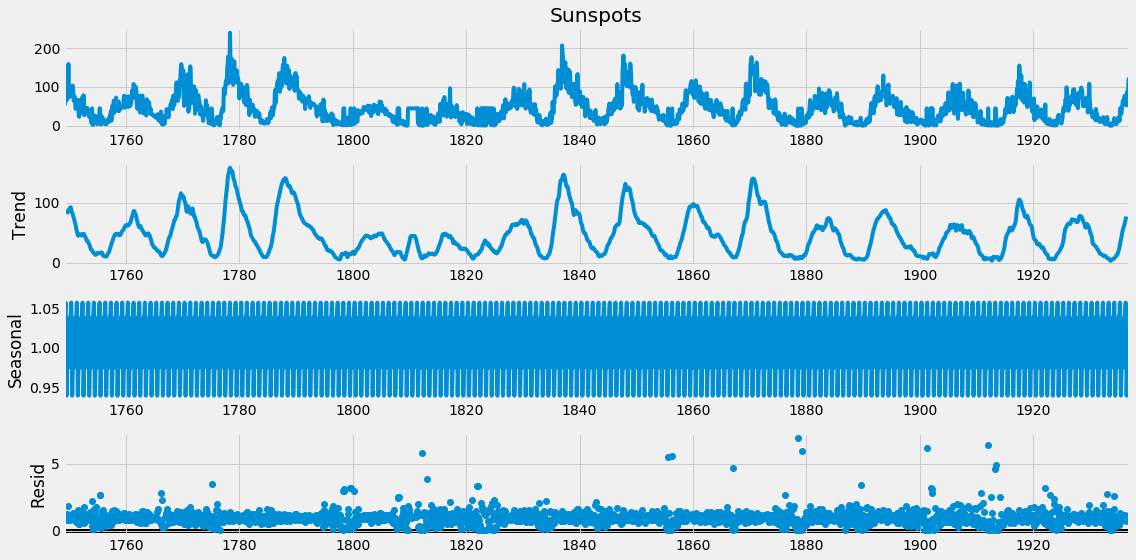

In [15]:
decomposition = seasonal.seasonal_decompose(new_train, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Let's check the stationarity of the Dataset: ( Augmented Dickey-Fuller 'ADF' test )


    #### the Null hypothesis in ADf test is:           -The given time series is non-stationary in nature 


    #### the alternate hypothesis in ADf test is:      -The time series is stationary in nature

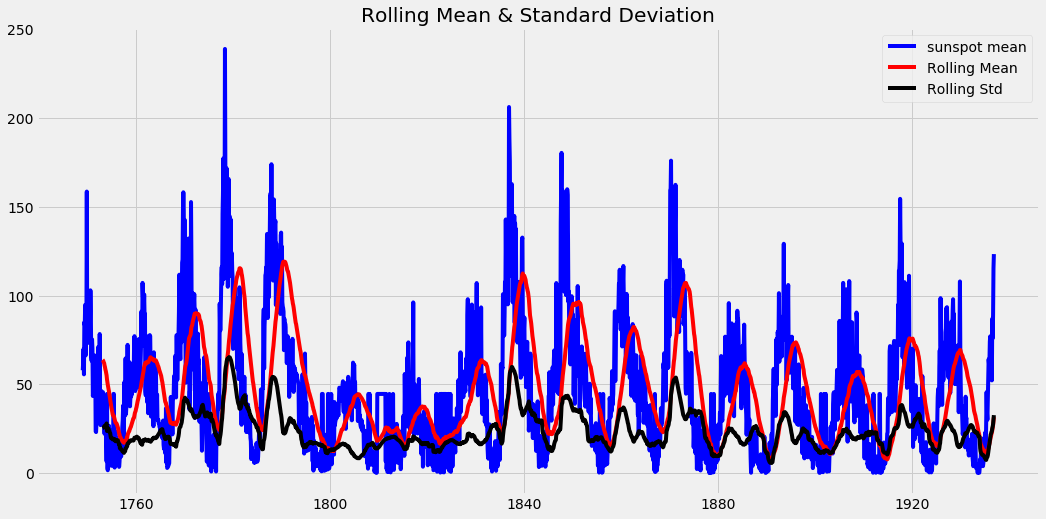

In [16]:
    #Determining rolling statistics
    rolmean = train.rolling(window = 50).mean()
    rolstd = train.rolling(window = 50).std()
    
    #plotting rolling statistics
    orig = plt.plot(train, color = 'blue', label = 'sunspot mean')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

### We can see that the mean (red line) and std deviation (black line) have a repeating pattern over the years, thus they have seasonal variations over time. 

    # Stationary Process: A process that generates a stationary series of observations.
    # Trend Stationary: A time series that does not exhibit a trend.
    # Seasonal Stationary: A time series that does not exhibit seasonality.

In [17]:
# ADF Test: check if our time series is stationary
X= new_train.values
result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    
if result[0]<result[4]["5%"]:
    print(" ==> Reject Ho : Our time series is stationary")
else: 
    print("==> Failed to reject Ho : Our time series is Non-stationary")

ADF Statistic: -7.935741581847938
p-value: 3.4175139727805047e-12
Critial Values:
   1%, -3.433287122798914
Critial Values:
   5%, -2.8628375359198617
Critial Values:
   10%, -2.5674607403348455
 ==> Reject Ho : Our time series is stationary


### the Dickey-Fuller test statistic result is less than the 5% critical value (the ADF statistic of our training set is equal to "2.306 e-12" which is almost 0.00 , the ADF statistic is then higher than the critical value for alpha = 5% (-2.863) ) thus the Time series is non-stationary within 95% confidence.
 
## ==> Hence, we do hold Ho & Our Dataset is  Stationary! 

## Based on the output of the Dickey-Fuller test, we do not need to differenciate the dataset before applying a base  ARIMA model. 

## ==> d = 0

### =====================================================================================

## Before applying ARIMA , Let's Create a Base-Line Model :  (naive method) to compare it with the ARIMA output at the end of the model
    ## the assumption states that the forecasted value t+1 gets the actual value of t ; this model is very naive and basic

In [18]:
value= pd.DataFrame(X)

In [19]:
sunspot_test_df= pd.concat([value,value.shift(1)], axis=1 ) 
#shift is a pandas method that implements the shift by one place un this case

In [20]:
sunspot_test_df.columns= ['actual_sunspot', 'forecasted_sunspot']
sunspot_test_df.head()

,actual_sunspot,forecasted_sunspot
0,58.0,NaN
1,62.6,58.0
2,70.0,62.6
3,55.7,70.0
4,85.0,55.7


In [21]:
#we should eliminate the line containing the "NAN" value since it's not of type float
sunspot_test= sunspot_test_df[1:]

In [22]:
sunspot_error= mean_squared_error(sunspot_test.actual_sunspot, sunspot_test.forecasted_sunspot)
sunspot_error

310.42984989760424

In [23]:
np.sqrt(sunspot_error)

17.619019549838868

#### As we might see, the error using this naive based technique is only 2.13, which is acceptable 
#### ==> the average error resulting for every date and by using the base-line naive technique is only 2 per sunspots

### =====================================================================================

## The next step is to apply the ARIMA model

    ## ARIMA stands for AUTO REGRESSIVE (p) INTEGRATED (d) MOVING AVERAGE (q) 
    ## The MOVING AVERAGE part is about eliminating the noise and smoothing the data makes it better to locate peaks and      fluctuations 
    ## The AUTO REGRESSIVE analyses the degree of correlation between the current an previous value (t and t-1) , it assumes that the previous value is the best reflection for the current value
    ## INTEGRATED refers to the order of differences ( The parameter "d") 

### * Before starting to identify and try different values of p & q ( through ACF and PACF), we should notice that, since the process is not stationary, differentiating the dataset is necessary. 

### Now Let's identify p and q: 

# ACF :
    #case of q 

In [24]:

from matplotlib import pyplot
%matplotlib inline 

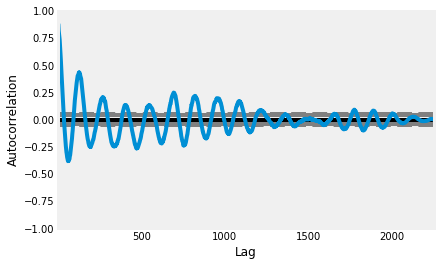

In [25]:
autocorrelation_plot(new_train)
pyplot.show()

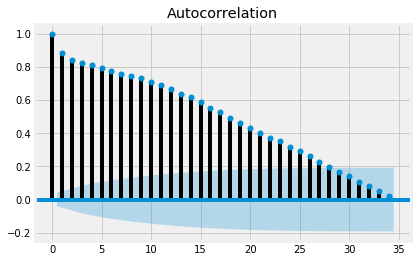

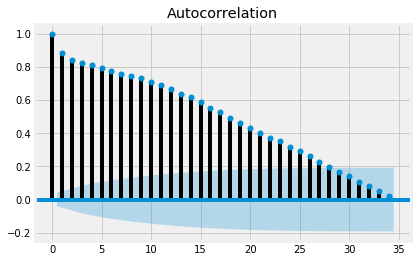

In [26]:
# plot_acf to identify parameter q: 
# ARIMA (p,d,q)
plot_acf(new_train)

####  we can notice that the autocorrelation score decases slowly over time, which indicates that the process is not a moving average.  
## q= 0


# PACF :
    # case of p

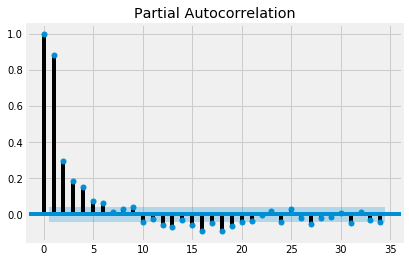

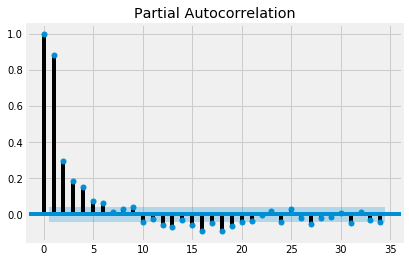

In [27]:
# plot_acf to identify parameter p: 
# ARIMA (p,d,q)
plot_pacf(new_train)

#### The values (t+1) to (t+5) with t=0 are exceeding the critical limit , so we should consider them 
#### The process is an Autoregressive of order up to 5 that we will experiment

### =====================================================================================

# ARIMA

### We will be trying different values of p with two different methods "MLE" and "CSS" in order to get the minimum AIC possible using ARIMA:

### *p= 1 to 6
### *d= 0
### *q= 0

In [28]:
decomposition = seasonal.seasonal_decompose(new_train) 

model1 = ARIMA(new_train, order=(1,0,0))
results_MLE = model1.fit(method="MLE")

model2 = ARIMA(new_train, order=(1,0,0))
results_CSS = model2.fit(method="CSS")


print(results_MLE.aic)
print(results_CSS.aic)

19219.525319260196
19210.389708815994


In [29]:
decomposition = seasonal.seasonal_decompose(new_train) 

model1 = ARIMA(new_train, order=(2,0,0))
results_MLE = model1.fit(method="MLE")

model2 = ARIMA(new_train, order=(2,0,0))
results_CSS = model2.fit(method="CSS")


print(results_MLE.aic)
print(results_CSS.aic)

19014.241651030537
18997.468481532185


In [30]:
decomposition = seasonal.seasonal_decompose(new_train) 

model1 = ARIMA(new_train, order=(3,0,0))
results_MLE = model1.fit(method="MLE")

model2 = ARIMA(new_train, order=(3,0,0))
results_CSS = model2.fit(method="CSS")


print(results_MLE.aic)
print(results_CSS.aic)

18939.668893758124
18915.092567032043


In [31]:
decomposition = seasonal.seasonal_decompose(new_train) 

model1 = ARIMA(new_train, order=(4,0,0))
results_MLE = model1.fit(method="MLE")

model2 = ARIMA(new_train, order=(4,0,0))
results_CSS = model2.fit(method="CSS")


print(results_MLE.aic)
print(results_CSS.aic)

18889.40263428866
18857.110194789184


In [32]:
decomposition = seasonal.seasonal_decompose(new_train) 

model1 = ARIMA(new_train, order=(5,0,0))
results_MLE = model1.fit(method="MLE")

model2 = ARIMA(new_train, order=(5,0,0))
results_CSS = model2.fit(method="CSS")


print(results_MLE.aic)
print(results_CSS.aic)

18879.708207053987
18837.24990300345


In [33]:
decomposition = seasonal.seasonal_decompose(train) 

model1 = ARIMA(new_train, order=(6,0,0))
results_MLE = model1.fit(method="MLE")

model2 = ARIMA(new_train, order=(6,0,0))
results_CSS = model2.fit(method="CSS")


print(results_MLE.aic)
print(results_CSS.aic)

18874.323474127996
18824.057786804187


### The lower is the AIC score (Akaike Information Criteria (model-order selection criterion )), the better is the model and the more suitable are the parameters: 

### Hence as shown in the output above, the best AR model so far is AR(6) represented by the ARIMA model (6,0,0) using the "CSS" method with an AIC score = 18824.0577 as the lowest one. 

#### =============================================================================================

## Applying ARIMA (using both ARIMA & SARIMAX methods) : 

In [34]:
mod = ARIMA(new_train, order=(6,0,0))
results = mod.fit(method="CSS")
print(results.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             46.5077      6.812      6.827      0.000      33.156      59.860
ar.L1.Sunspots     0.5247      0.021     24.915      0.000       0.483       0.566
ar.L2.Sunspots     0.1415      0.024      5.955      0.000       0.095       0.188
ar.L3.Sunspots     0.0808      0.024      3.389      0.001       0.034       0.128
ar.L4.Sunspots     0.1047      0.024      4.391      0.000       0.058       0.151
ar.L5.Sunspots     0.0420      0.024      1.767      0.077      -0.005       0.089
ar.L6.Sunspots     0.0574      0.021      2.719      0.007       0.016       0.099


In [35]:
# we will be also implementing the SARIMAX test to exploit its attribute "plot-diagnostics" 
# The attribute will help us visualize the diagnostics of our ARIMA model
sarimax_mod= SARIMAX(new_train, order=(6,0,0) , enforce_stationarity=False, enforce_seasonality=True ,enforce_invertibility=False)
sarimax_results = sarimax_mod.fit()

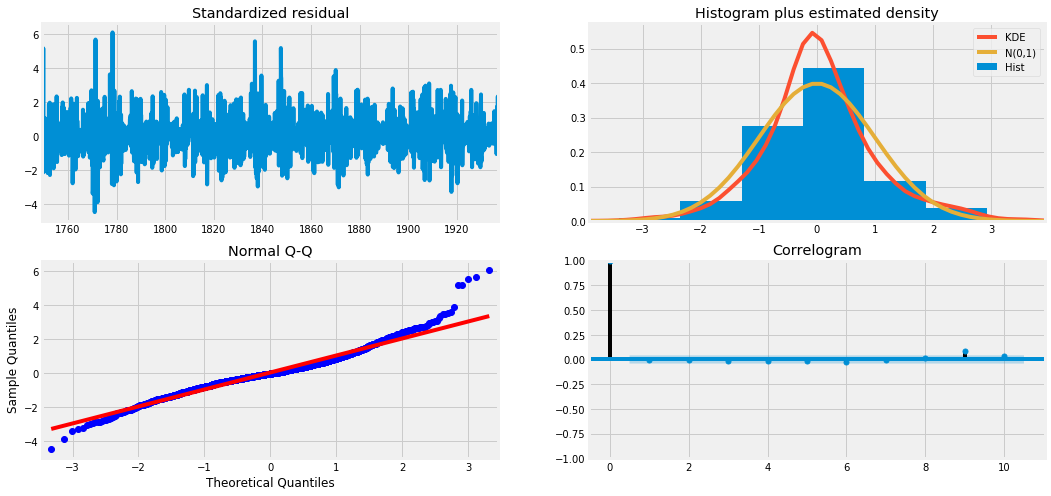

In [36]:
sarimax_results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Our model diagnostics suggests that the model residuals are near normally distributed.

## Now, Let's forecast the test set: 

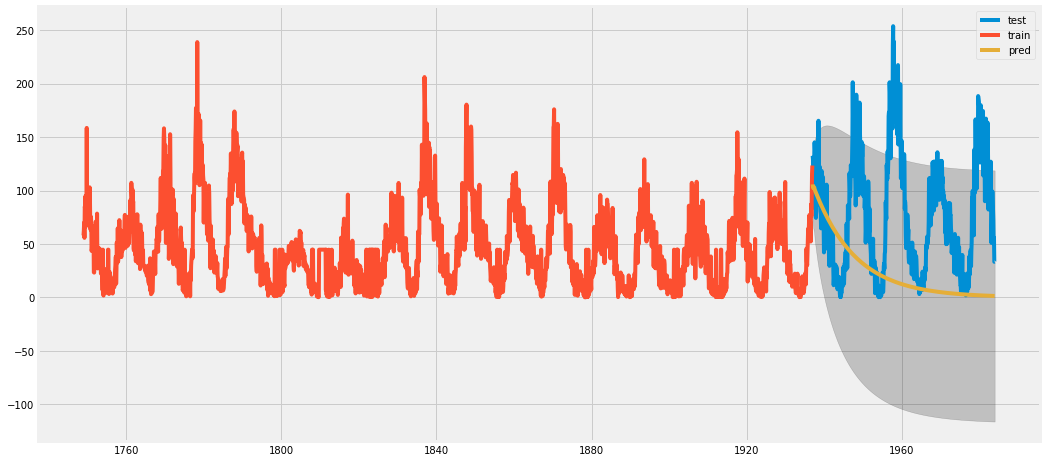

In [37]:
pred = sarimax_results.get_prediction(start=pd.to_datetime('1937-01-01'),end=pd.to_datetime('1983-12-01'), dynamic=False)
pred_ci = pred.conf_int()

plt.figure(figsize=(16,8))
prediction = pred.predicted_mean.to_frame()
prediction.index = pd.to_datetime(prediction.index)
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
prediction.columns=['Sunspots']
plt.plot(test, label="test")
plt.plot(train, label="train")
plt.plot(prediction, label="pred")
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.2)
plt.legend()
plt.show()

### Mean Squared Error MSE: 

In [38]:
np.sqrt(mean_squared_error(test,prediction))

81.7211622042709

### the accuracy of our forecast is given by the MSE (81.721), which is relatively big. Other forecast models can be implemented and be more well performing.

## "81.72" which is the ARIMA model result, is very big comparing to the naive model (base-line model) which is "2.131" 
## In this case, we prefer using the Naive model to forecast future data instead of ARIMA